# Initilization

In [1]:
import sklearn

import pandas as pd

import matplotlib.pyplot as plt

import torch

import numpy as np

import seaborn as sns

import pygwalker as pyg

from tqdm import tqdm

from torch import nn

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

import sklearn.linear_model as lm

from scipy.stats import zscore

import scipy.stats as st

from scipy.linalg import svd # Singular value decomposition package

import torchmetrics # used for evaluation metrics

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier

from sklearn.inspection import DecisionBoundaryDisplay

from itertools import product

from sklearn import svm 

c:\Users\emirh\anaconda3\envs\MachineLearning\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
filename_data = "Data/Abalone/abalone.data" # path to our data

data_frame = pd.read_csv(filename_data,header = None) # our dataframe without the header

data_frame = data_frame.replace("M","A") # changing the male adult to just adult

data_frame = data_frame.replace("F","A") # changing the female adult to just adult

sex_data = list(data_frame.iloc[:,0]) # we extract all the sex_data

class_labels = sex_data # our class labels is precisely our sex_data

class_names = sorted(set(class_labels)) # we make a list of class names

class_dict = dict(zip(class_names, range(3))) # we assign a value to each of our class_names

class_data = np.asarray([class_dict[value] for value in class_labels]) # we give our data the appropriate value

# Our attribute name

attribute_name = ["Sex", "Length (mm)", "Diameter (mm)", "height (mm)", "Whole weight (g)", "Shucked weight (g)", "Viscera weight (g)", "Shell weight (g)", "Rings"]

data_frame.columns = attribute_name # our data_frame gets assigned the attribute name

data_frame.iloc[:,1:8] = data_frame.iloc[:,1:8]*200 # the original source divided the continouous values by 200 - we scale them back up


In [4]:
gwalker = pyg.walk(data_frame)

Box(children=(HTML(value='<div id="ifr-pyg-0" style="height: auto">\n    <head>\n        <meta http-equiv="Con…

We will now standardize our data by using scipy's zscore function

In [6]:
# we will make our sub_data, which is just our data_frame without the class labels

sub_data = data_frame.iloc[:,1:]

standardized_data = zscore(sub_data, ddof = 1) # ddof = degree of freedom

standardized_data

# to do it manually - you can do it this way

# manual way

#mean_list = list(sub_data.mean())

#Y = sub_data - np.ones((N,len(mean_list))) * mean_list

#Y_manual_standardized = Y.astype(np.float64)

#Y_manual_standardized = Y_manual_standardized * 1 / np.std(Y_manual_standardized, axis = 0)


,Length (mm),Diameter (mm),height (mm),Whole weight (g),Shucked weight (g),Viscera weight (g),Shell weight (g),Rings
0,-0.574489,-0.432097,-1.064297,-0.641821,-0.607613,-0.726125,-0.638140,1.571355
1,-1.448812,-1.439757,-1.183837,-1.230130,-1.170770,-1.205077,-1.212842,-0.909904
2,0.050027,0.122116,-0.107978,-0.309432,-0.463444,-0.356647,-0.207114,-0.289589
3,-0.699393,-0.432097,-0.347058,-0.637743,-0.648160,-0.607527,-0.602222,0.020568
4,-1.615350,-1.540523,-1.422916,-1.271933,-1.215822,-1.287183,-1.320599,-0.909904
...,...,...,...,...,...,...,...,...
4172,0.341468,0.424414,0.609261,0.118799,0.047902,0.532836,0.073053,0.330726
4173,0.549640,0.323648,-0.107978,0.279896,0.358765,0.309325,0.155666,0.020568
4174,0.632909,0.676328,1.565580,0.708127,0.748470,0.975296,0.496895,-0.289589
4175,0.841081,0.777094,0.250642,0.541933,0.773248,0.733540,0.410690,0.020568


# Simple data visualization

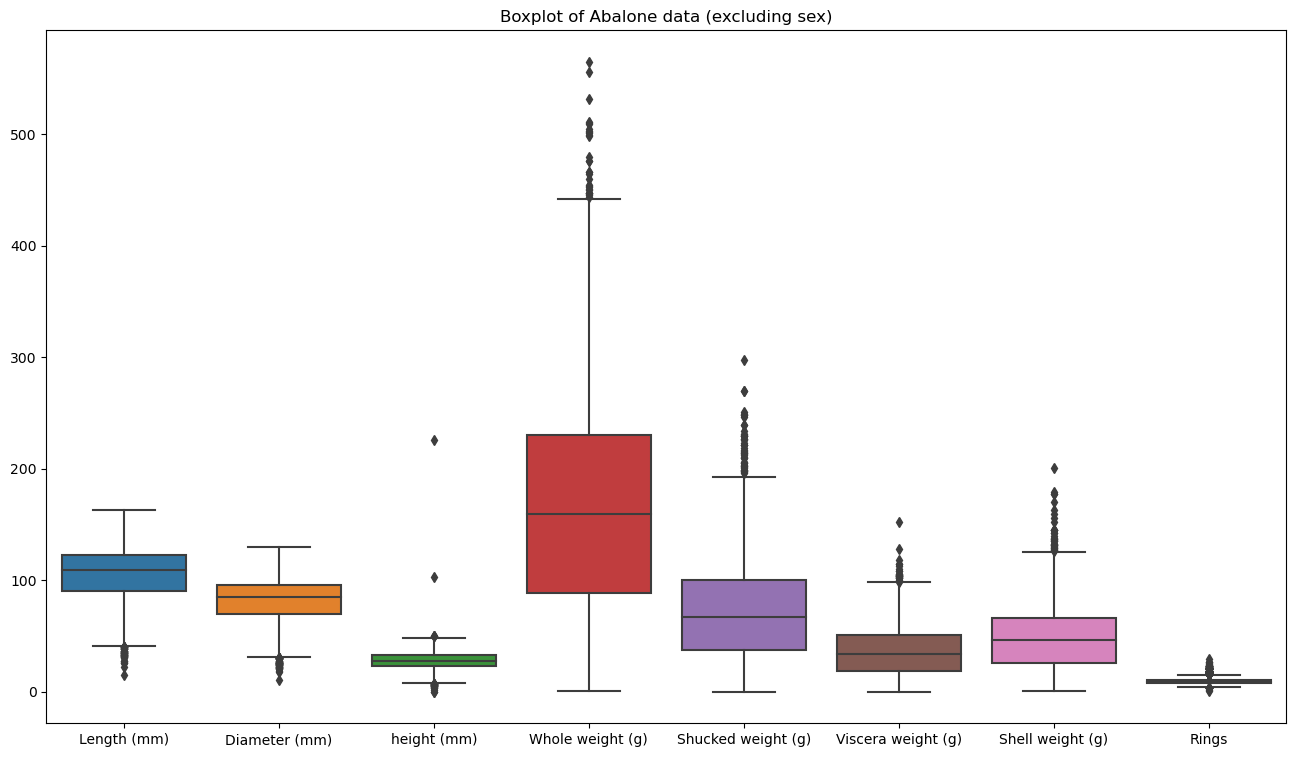

In [8]:
## Boxplot ## 

plt.figure(figsize= (16,9))
sns.boxplot(data=sub_data).set(title='Boxplot of Abalone data (excluding sex)')
plt.show()

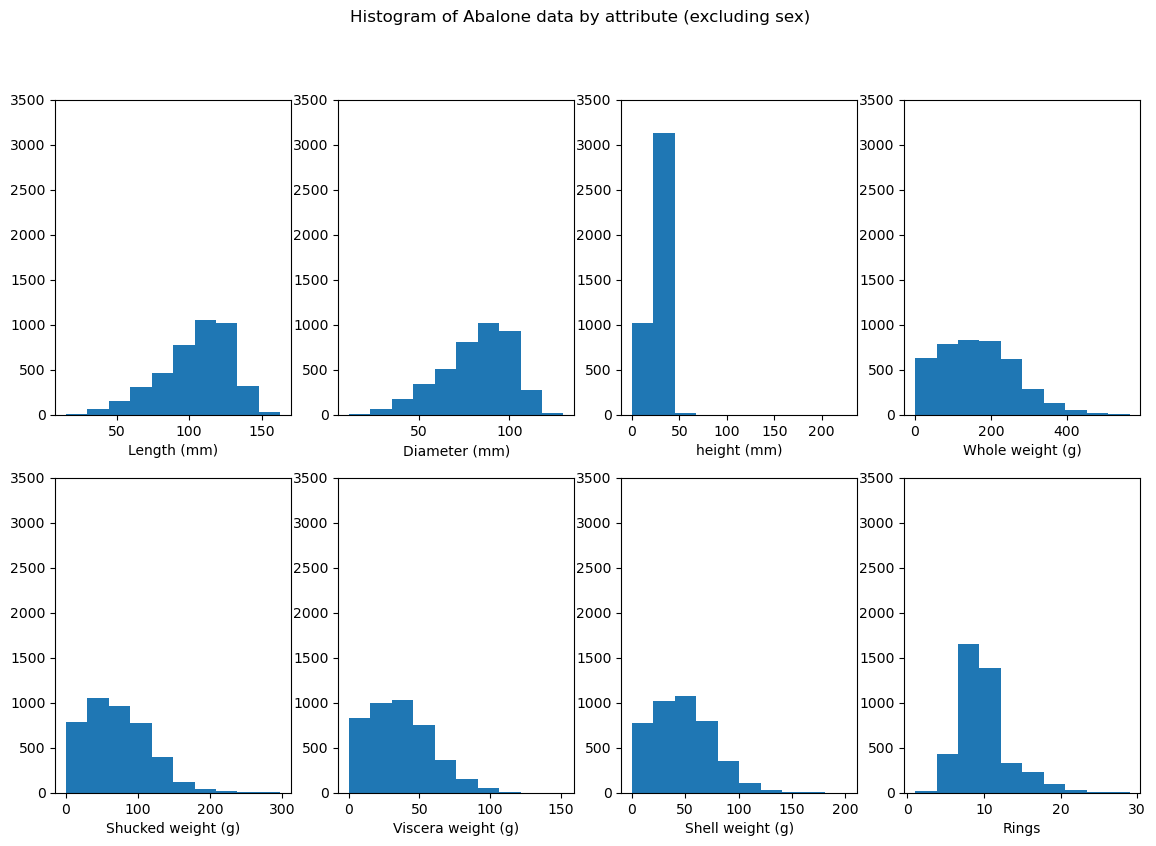

In [9]:
M = len(attribute_name)-1 # number of attribute names

plt.figure(figsize=(14,9))
u = int(np.floor(np.sqrt(M))); v = int(np.ceil(float(M)/u))
for i in range(M):
    plt.subplot(u,v,i+1)
    plt.hist(sub_data.iloc[:,i])
    plt.xlabel(attribute_name[i+1])
    plt.ylim(0,3500)
plt.suptitle("Histogram of Abalone data by attribute (excluding sex)")
plt.show()

It is clear that most of the attributes are distributed quite normally, which does make sense, since CLT  (sampling distribution of the mean) will approximately be normal if enough observations are present, which it is in this case.

Intuitively, the weights should be somewhat correlated - this can be shown by doing a pairplot, where you plot a pair of attributes with each other.

<Figure size 640x480 with 0 Axes>

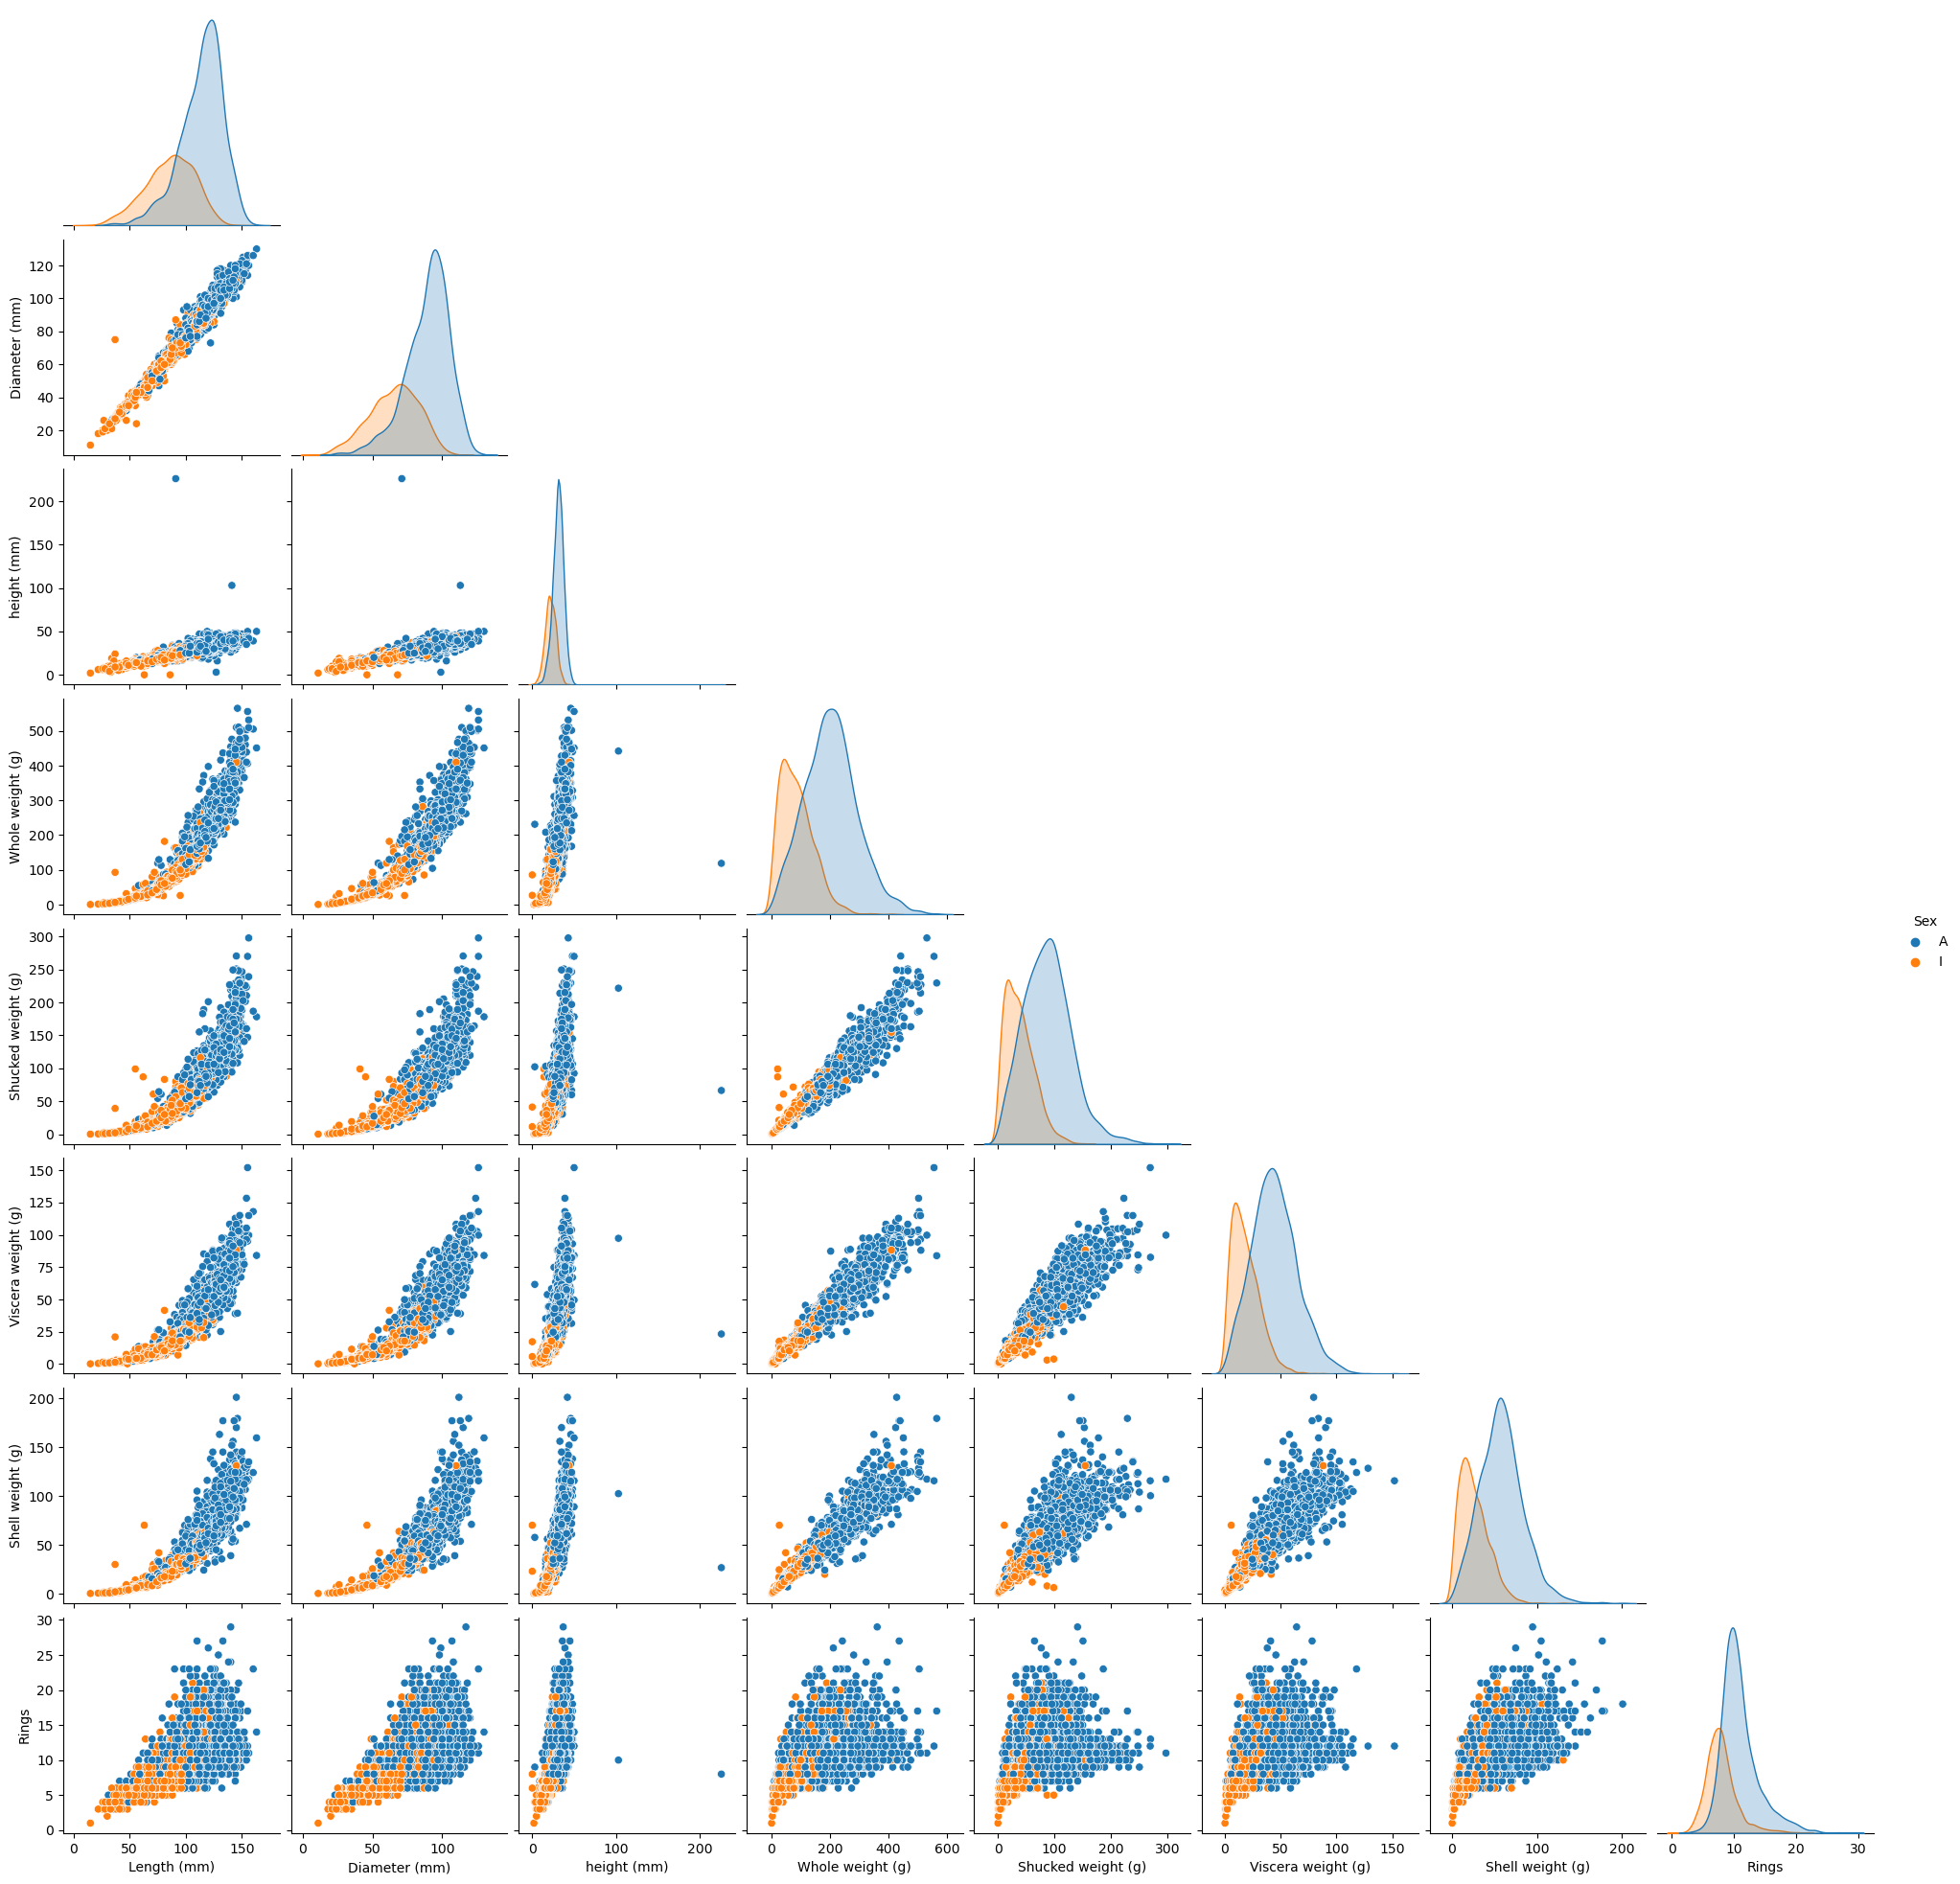

In [10]:
plt.figure()
sns.pairplot(data_frame, hue = "Sex", corner = True) # we use the original data, to have our hue parameter
plt.show()

As expected, many of the attributes are correlated - especially the aforementioned attributes - thus a PCA analysis can be done to reduce the dimensionality of our dataset without losing the essence of what the dataset tells us

# PCA analysis

To reduce the dimensionality of our data, a PCA analysis has been done - scipy's svd function has been used

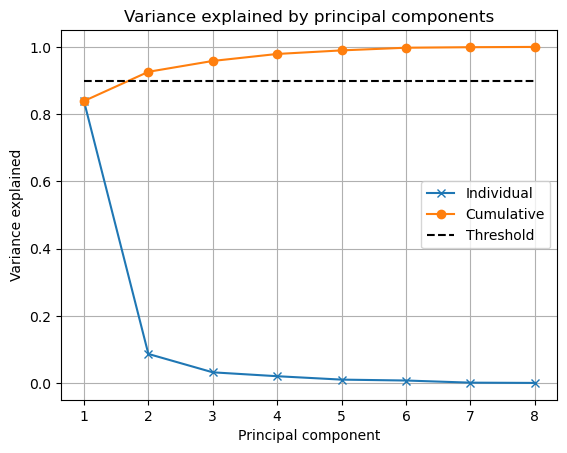

In [11]:
U,S,V = svd(standardized_data,full_matrices=False)

# Compute variance explained by principal components

rho = (S*S) / (S*S).sum() # The way to compute the individual rho,

threshold = 0.9

# Plotting variance explained.
plt.figure()
plt.plot(range(1,len(rho)+1),rho,'x-')
plt.plot(range(1,len(rho)+1),np.cumsum(rho),'o-')
plt.plot([1,len(rho)],[threshold, threshold],'k--')
plt.title('Variance explained by principal components');
plt.xlabel('Principal component');
plt.ylabel('Variance explained');
plt.legend(['Individual','Cumulative','Threshold'])
plt.grid()
plt.show()


We'll now plot our data point in a 2D PC space

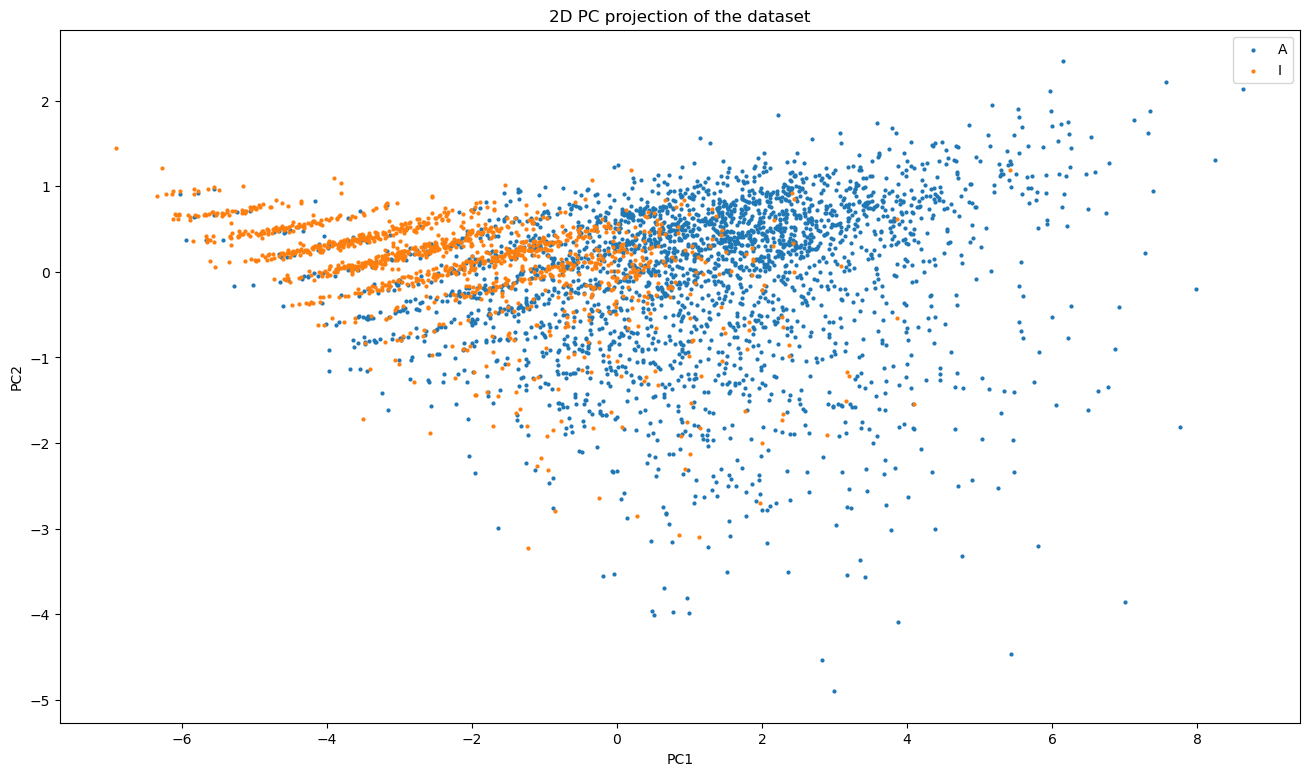

In [12]:
Vh = V.T

# Projecting the data onto the PC space

Z = standardized_data @ Vh

PCA_data_2 = Z.iloc[:,0:2].to_numpy() # PCA_data of the first 2 data

# Plot PCA of the data
f = plt.figure(figsize=(16,9))
plt.title("2D PC projection of the dataset")
#Z = array(Z)

C = len(class_names) # number of class names

i = 0 # first PC
j = 1 # second PC

for c in range(C):
    # select indices belonging to class c:
    class_mask = class_data==c
    plt.scatter(Z.iloc[class_mask,i], Z.iloc[class_mask,j], s=4)
plt.legend(class_names)
plt.xlabel('PC{0}'.format(i+1))
plt.ylabel('PC{0}'.format(j+1))

# Output result to screen
plt.show()

It is clear, that the different classes have a quite significant overlap, but also area where it is most definitely distinguishable between the two classes

We will now display the coefficients of the first 2 PCs to get a clear understanding which attributes are significant. :D

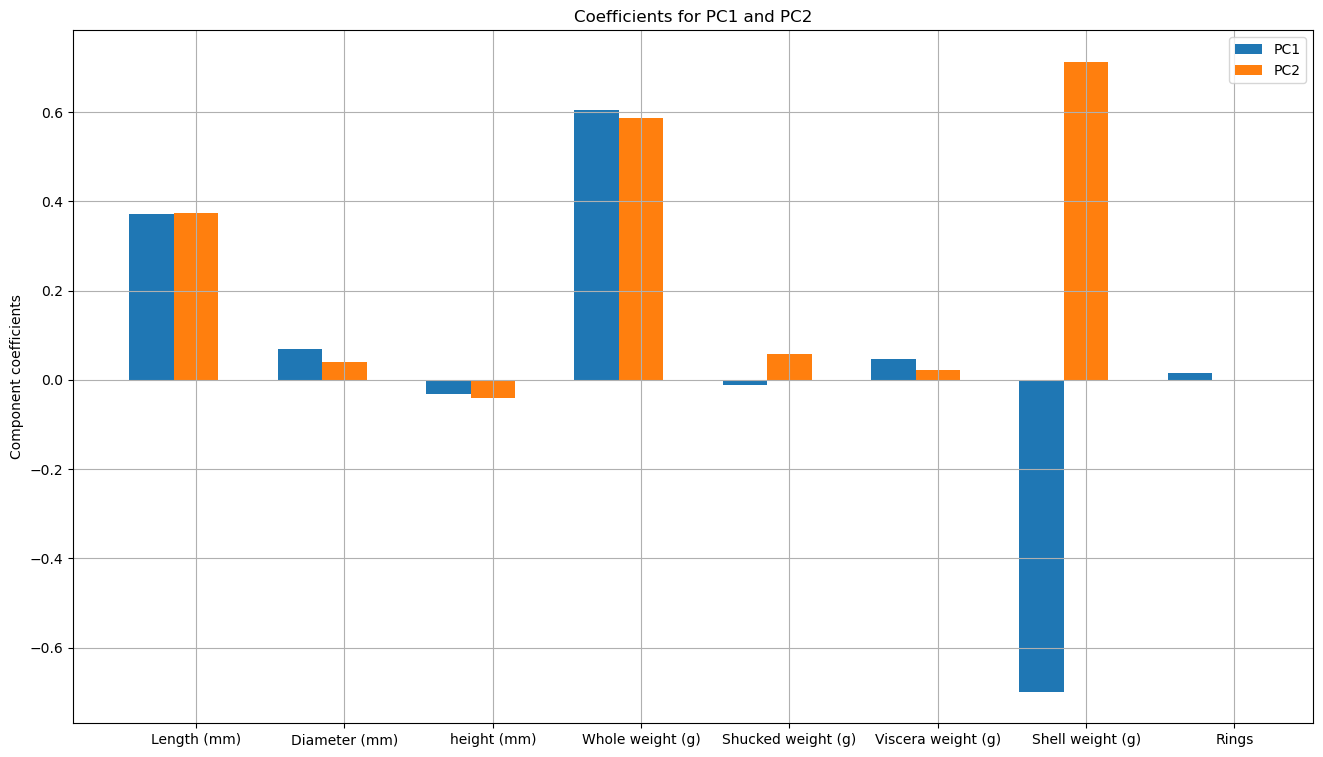

In [13]:
pcs = [0,1] # first and second PC

legendStrs = ['PC'+str(e+1) for e in pcs] # appropriate legend for them

bw = 0.3
r = np.arange(1, M+1) # list of our attributes

plt.figure(figsize=(16,9))
for i in pcs:    
    plt.bar(r+i*bw, V[:,i], width=bw)
plt.xticks(r+bw, attribute_name[1:])
plt.ylabel('Component coefficients')
plt.legend(legendStrs)
plt.grid()
plt.title('Coefficients for PC1 and PC2')
plt.show()

As seen, the main driving forces are Length, Whole weight and Shell weight.

# Regression analysis

It would be useful to be able to estimate the viscera weight based on the other attributes in order to accurately predict the weight, to refrain from using complicated, time-consuming processes to determine the viscera weight

In order to do this, we'll make a regularized linear regression, and for that a function will be constructed that will suficiently carries it out.

The function will do it by using a fixed number of cross-validation folds

In [14]:
def rlr_validate(data,y,lambdas,n_cv=10):
    ''' Validate regularized linear regression model using cross-validation fold.
        Find the optimal lambda (minimizing validation error) from 'lambdas' list.
        The loss function computed as mean squared error on validation set (MSE).

        Function returns: MSE averaged over cross-validation folds, optimal value of lambda,
        average weight values for all lambdas, MSE for  train and validation errors for all lambdas.
        The cross validation splits are standardized based on the mean and standard
        deviation of the training set when estimating the regularization strength.
        
        Parameters:
        data:       training data set
        y:       vector of values that needs to be estimated
        lambdas: vector of lambda values to be validated
        n_cv:     number of crossvalidation folds     
        
        Returns:
        opt_val_err:         validation error for optimum lambda
        opt_lambda:          value of optimal lambda
        mean_w_vs_lambda:    weights as function of lambda (matrix)
        train_err_vs_lambda: train error as function of lambda (vector)
        test_err_vs_lambda:  test error as function of lambda (vector)
    '''
    CV = KFold(n_cv, shuffle=True) # making n_cv of cross-validation folds

    M = data.shape[1]


    # Make a list of variables to store our results / returns

    w = np.empty((M,n_cv,len(lambdas)))

    train_error = np.empty((n_cv,len(lambdas)))

    test_error = np.empty((n_cv,len(lambdas)))

    counter = 0 # we make a counter to index in the appropriate places

    y = y.squeeze() # we squeeze our value dataset, to remvoe any 1-dimensionality


    # for loop that will create our cross validation

    for train_index, test_index in tqdm(CV.split(data,y)):
        X_train = data[train_index]
        y_train = y[train_index]
        X_test = data[test_index]
        y_test = y[test_index]
        
        # Standardizing the training and test set
        mu = np.mean(X_train[:, 1:], 0) # mean by column
        std = np.std(X_train[:, 1:], 0) # std by column
        
        X_train[:, 1:] = (X_train[:, 1:] - mu) / std # standardizing the data
        X_test[:, 1:] = (X_test[:, 1:] - mu) / std # standardizing the data
        
        # precomputing the terms
        Xty = X_train.T @ y_train

        XtX = X_train.T @ X_train

        # looping through each lambda term
        for l in tqdm(range(0,len(lambdas))):

            # Compute parameters for current value of lambda and current CV fold

            lambdaI = lambdas[l] * np.eye(M)

            lambdaI[0,0] = 0 # remove bias 
            
            w[:,counter,l] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()

            # Evaluate training and test performance

            train_error[counter,l] = np.power(y_train-X_train @ w[:,counter,l].T,2).mean(axis=0)
            test_error[counter,l] = np.power(y_test-X_test @ w[:,counter,l].T,2).mean(axis=0)
    
        counter += 1

    # optaining the optimal errors and mean of the errors
    opt_val_err = np.min(np.mean(test_error,axis=0))
    opt_lambda = lambdas[np.argmin(np.mean(test_error,axis=0))]
    train_err_vs_lambda = np.mean(train_error,axis=0)
    test_err_vs_lambda = np.mean(test_error,axis=0)
    mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))
    
    return opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda
        

Now that we have the function, we'll create the appropriate data - that is y = viscera weight and our data being the rest with an offset of 1s in the first column

In [15]:
y = data_frame["Viscera weight (g)"]

y = zscore(y, ddof = 1) # ddof = degree of freedom - standardizing our y-value

y = y.to_numpy() # converting it to numpy array

regression_data = data_frame.drop(columns=["Sex","Viscera weight (g)"])

regression_data = zscore(regression_data, ddof = 1) # ddof = degree of freedom

# adding the 1 vector as offset to the regression and converting our data to a numpy array.

regression_data =  np.concatenate((np.ones((regression_data.shape[0],1)),regression_data.to_numpy()),1)

attribute_name = ['Offset']+["Length (mm)",
"Diameter (mm)", "height (mm)",
"Whole weight (g)", "Shucked weight (g)",
"Shell weight (g)", "Rings"]


A 2-layer cross validation will be constructed, to get the optimal lambda-value and use that to calculate our outer fold losses

In [16]:
lambdas = np.power(10.,range(-5,7)) # the range we will test our lambda values

K = 10 # number of folds in the outer layer

CV = KFold(K, shuffle=True)

error_train = np.empty((K,1))
error_test = np.empty((K,1))
error_train_rlr = np.empty((K,1))
error_test_rlr = np.empty((K,1))
error_train_nofeatures = np.empty((K,1))
error_test_nofeatures = np.empty((K,1))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

The calculation will now be done

100%|██████████| 12/12 [00:00<00:00, 1500.56it/s]
10it [00:00, 27.03it/s]
100%|██████████| 12/12 [00:00<00:00, 857.12it/s]
10it [00:00, 35.26it/s]
100%|██████████| 12/12 [00:00<00:00, 586.99it/s]
10it [00:00, 35.34it/s]
100%|██████████| 12/12 [00:00<00:00, 666.88it/s]
10it [00:00, 14.77it/s]
100%|██████████| 12/12 [00:00<00:00, 857.23it/s]
10it [00:00, 33.11it/s]
100%|██████████| 12/12 [00:00<00:00, 292.70it/s]
10it [00:00, 16.37it/s]
100%|██████████| 12/12 [00:00<00:00, 1201.18it/s]
10it [00:00, 21.59it/s]
100%|██████████| 12/12 [00:00<00:00, 1199.49it/s]
10it [00:00, 40.16it/s]
100%|██████████| 12/12 [00:00<00:00, 1333.61it/s]
10it [00:00, 50.00it/s]
100%|██████████| 12/12 [00:00<00:00, 1999.91it/s]
10it [00:00, 42.28it/s]


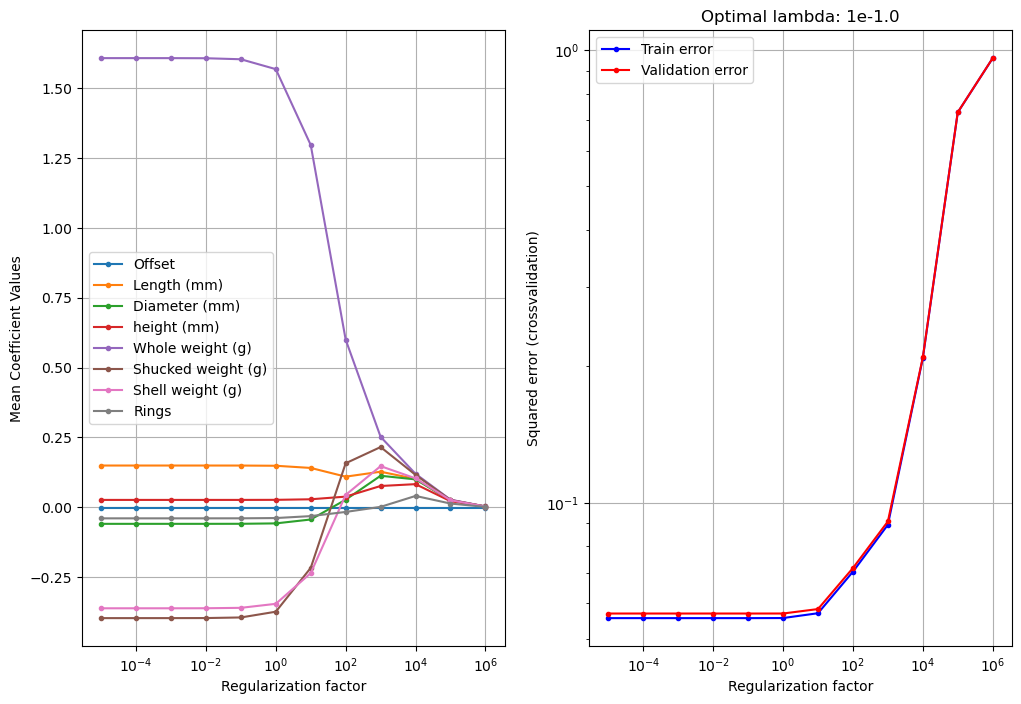

Linear regression without feature selection:
- Training error: 0.05680616967062026
- Test error:     0.05807140108576101
- R^2 train:     0.9431780132803979
- R^2 test:     0.9417309486225824

Regularized linear regression:
- Training error: 0.05680798431065755
- Test error:     0.05808709895036836
- R^2 train:     0.9431761981350941
- R^2 test:     0.9417151973291366

Weights in last fold:
         Offset             0.0
    Length (mm)            0.15
  Diameter (mm)           -0.06
    height (mm)            0.02
Whole weight (g)            1.62
Shucked weight (g)            -0.4
Shell weight (g)           -0.36
          Rings           -0.04


In [17]:

index=0

for train_index, test_index in CV.split(regression_data):
    # extract training and test set for current CV fold
    X_train = regression_data[train_index]
    y_train = y[train_index]
    X_test = regression_data[test_index]
    y_test = y[test_index]

    internal_cross_validation = 10 

    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    error_train_nofeatures[index] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    error_test_nofeatures[index] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # not regularizing the bias term (the offset term)

    w_rlr[:,index] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()

    # Compute mean squared error with regularization with optimal lambda
    error_train_rlr[index] = np.square(y_train-X_train @ w_rlr[:,index]).sum(axis=0)/y_train.shape[0]
    error_test_rlr[index] = np.square(y_test-X_test @ w_rlr[:,index]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,index] = np.linalg.solve(XtX,Xty).squeeze()
    
    # using sklearn.linear_model module for linear regression estimation
    m = lm.LinearRegression().fit(X_train, y_train)
    error_train[index] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0] # calculation of the error
    error_test[index] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0] # calculation of the error.

    # Display the results for the last cross-validation fold
    if index == K-1:
        plt.figure(index, figsize=(12,8))
        plt.subplot(1,2,1)
        plt.semilogx(lambdas,mean_w_vs_lambda.T,'.-') # Don't plot the bias term
        plt.xlabel('Regularization factor')
        plt.ylabel('Mean Coefficient Values')
        plt.grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        plt.legend(attribute_name, loc='best')
        
        plt.subplot(1,2,2)
        plt.title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        plt.loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        plt.xlabel('Regularization factor')
        plt.ylabel('Squared error (crossvalidation)')
        plt.legend(['Train error','Validation error'])
        plt.grid()
    
    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    index += 1

plt.show()

# Displaying the results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(error_train.mean()))
print('- Test error:     {0}'.format(error_test.mean()))
print('- R^2 train:     {0}'.format((error_train_nofeatures.sum()-error_train.sum())/error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((error_test_nofeatures.sum()-error_test.sum())/error_test_nofeatures.sum()))

print('Regularized linear regression:')
print('- Training error: {0}'.format(error_train_rlr.mean()))
print('- Test error:     {0}'.format(error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((error_train_nofeatures.sum()-error_train_rlr.sum())/error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((error_test_nofeatures.sum()-error_test_rlr.sum())/error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(attribute_name[m], np.round(w_rlr[m,-1],2)))

It is clear based on the weights in the last fold, that the weights have the biggest "weights" associated with them - as expected from earlier


It is also clear that (based on the R^2 test), that our regularized linear regression estimates the viscera weight quite well

# Linear regression with an artificial neural network

It would be interesting to investigate and check how well an ANN will perform on regression

We will perform a 2-layer cross validation, and randomly sample random number of hidden units in the ANN

to do that, we will first create our ANN model

In [18]:
class ANN_reg_model(nn.Module):

    def __init__(self, input_features, output_features, hidden_units = 3): # preset hidden units to 3

        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.ReLU(), # Relu activation function inbetween
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(), # Relu activation function inbetween
            nn.Linear(in_features= hidden_units, out_features = output_features) # last layer
        )

    # need our forward pass / selection

    def forward(self, x):

        return self.linear_layer_stack(x) # making the forward pass

The model was created arbitrarily, since which activation functions you use (ReLU, Tanh, sigmoid, etc.), how many hidden layers you make, the number of hidden units you have in different layers, etc.

In [19]:

# setting up the number of cross validations for both outer and inner

K_outer = 10

K_inner = 10

CV_outer = KFold(K_outer,shuffle=True)

CV_inner = KFold(K_inner,shuffle=True)

outer_counter = 0

max_iter = 3000 # maximum number of iterations we will be doing per evaluation

# constructing outer variables that we will fill out

error_ann = np.zeros(K_outer)

n_hidden_units_vec = np.zeros(K_outer)

loss_fn = torch.nn.MSELoss() # MSE will be our loss function

# for loop that iterates through each outer cross validation

for train_index_outer, test_index_outer in CV_outer.split(regression_data):

    # creating the necessary outer fold test- and train data

    X_train_outer_ann = torch.Tensor(regression_data[train_index_outer,:])
    y_train_outer_ann = torch.Tensor(y[train_index_outer])
    X_test_outer_ann = torch.Tensor(regression_data[test_index_outer,:])
    y_test_outer_ann = torch.Tensor(y[test_index_outer])
    X_train_outer = regression_data[train_index_outer]
    
    # variable that will have the error from the inner fold
    error_inner_ann = np.zeros(K_inner)
    
    inner_counter = 0 # inner CV counter
    
    n_hidden_units = np.random.choice(np.arange(1,5), 1) # randomly picking a random number of hidden units in our layers

    n_hidden_units_vec[outer_counter] = n_hidden_units[0]
    
    # looping through inner cross validation layer.

    for train_index_inner, test_index_inner in CV_inner.split(X_train_outer):
        
        # creating the necessary inner fold test- and train data

        X_train_inner_ann = torch.Tensor(X_train_outer_ann[train_index_inner,:])
        y_train_inner_ann = torch.Tensor(y_train_outer_ann[train_index_inner])
        X_test_inner_ann = torch.Tensor(X_train_outer_ann[test_index_inner,:])
        y_test_inner_ann = torch.Tensor(y_train_outer_ann[test_index_inner])
        # a place to store the errors for each picked n_hidden_units

        error_h = np.zeros(max_iter)

        ann_counter = 0
        
        # looping through each hidden unit number in our n_hidden_units vector

        for h in n_hidden_units:
            
            # creating a model with the given number of hidden units

            model = ANN_reg_model(input_features = M, # we have M+1 attributes which needs to be our input layer (since we have included our bias term)
            output_features= 1, # we have 1 attribute (viscera weight) as our output layer
            hidden_units = h)

            optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.1) # a lot of different optimizers could have been picked
            
            for epoch in range(max_iter):

                model.train() # train mode in pytorch set all parameters that require gradient
                # to require gradients

                # doing the forward pass

                y_pred = model(X_train_inner_ann).squeeze()
                
                # calculating the loss

                loss = loss_fn(y_pred, y_train_inner_ann)

                # we will put the optimizer back to 0 to not accumulate the loss

                optimizer.zero_grad()

                # Perform backpropagation on the loss with respect to the parameters of the model

                loss.backward()

                # we will now perform our optimizer step (in this case adam)

                optimizer.step()

                ### Testing part ###

                with torch.inference_mode():

                    # doing the forward pass

                    test_pred = model(X_test_inner_ann).squeeze()

                    # calculating the loss

                    error_h[ann_counter] = loss_fn(test_pred, y_test_inner_ann)

                    ann_counter += 1

        error_inner_ann[inner_counter] = np.min(error_h)
        
        inner_counter += 1
    
    # Error calculation
    
    error_ann[outer_counter] = np.min(error_inner_ann) 
    
    outer_counter += 1


We will now visualize these train and test errors from our ANN

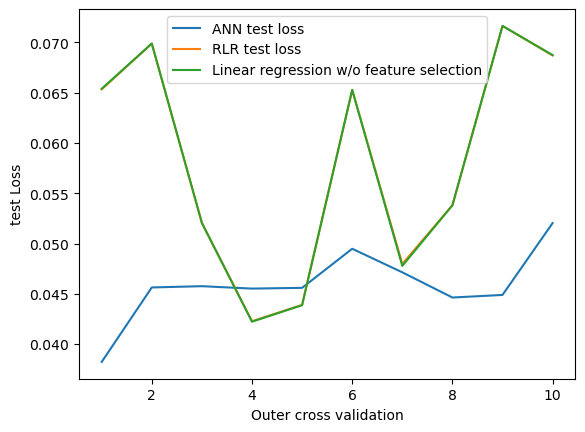

In [20]:
outer_CV_range = np.arange(1,K+1) # range from 1 to 10

plt.plot(outer_CV_range,error_ann, label = "ANN test loss")

plt.plot(outer_CV_range,error_test_rlr, label = "RLR test loss")

plt.plot(outer_CV_range,error_test, label = "Linear regression w/o feature selection")

plt.ylabel("test Loss")

plt.xlabel("Outer cross validation")

plt.legend()




generally speaking they are quite similar in performance - however - can statistically say that one method is performing better than the other? We can do this by doing a T-test

In [21]:

# testing the null hypothesis

z_rlr_reg=  error_test_rlr.squeeze() - error_test.squeeze()
z_rlr_ann = error_test_rlr.squeeze() - error_ann.squeeze()
z_ann_reg = error_ann.squeeze() - error_test.squeeze()

alpha = 0.05 # our alpha value -> 0.05 = 5% significance value.

# we now use the t-statistic to determine the confidence interval (CI) and p-value for each comparison

CI_rlr_reg = st.t.interval(1-alpha, len(z_rlr_reg)-1, loc=np.mean(z_rlr_reg), scale=st.sem(z_rlr_reg))  # Confidence interval
p_rlr_reg = 2*st.t.cdf( -np.abs( np.mean(z_rlr_reg) )/st.sem(z_rlr_reg), df=len(z_rlr_reg)-1)  # p-value

CI_rlr_ann = st.t.interval(1-alpha, len(z_rlr_ann)-1, loc=np.mean(z_rlr_ann), scale=st.sem(z_rlr_ann))  # Confidence interval
p_rlr_ann = 2*st.t.cdf( -np.abs( np.mean(z_rlr_ann) )/st.sem(z_rlr_ann), df=len(z_rlr_ann)-1)  # p-value

CI_ann_reg = st.t.interval(1-alpha, len(z_ann_reg)-1, loc=np.mean(z_ann_reg), scale=st.sem(z_ann_reg))  # Confidence interval
p_ann_reg = 2*st.t.cdf( -np.abs( np.mean(z_ann_reg) )/st.sem(z_ann_reg), df=len(z_ann_reg)-1)  # p-value


# get each variable into a list and convert that into a pandas dataframe

CI_low_list = [CI_rlr_reg[0], CI_rlr_ann[0], CI_ann_reg[0]]

CI_high_list = [CI_rlr_reg[1], CI_rlr_ann[1], CI_ann_reg[1]]

p_list = [p_rlr_reg, p_rlr_ann, p_ann_reg]

comparison_list = ["rlr vs regression", "rlr vs ANN", "ANN vs regression"]

statistic_dict = {"P-value": p_list,
"CI lower bound" : CI_low_list,
"CI upper bound" : CI_high_list,
"Comparison": comparison_list}

statistic_df = pd.DataFrame(data = statistic_dict)

statistic_df

,P-value,CI lower bound,CI upper bound,Comparison
0,0.488642,-0.000033,0.000065,rlr vs regression
1,0.009008,0.003873,0.020514,rlr vs ANN
2,0.009243,-0.020528,-0.003828,ANN vs regression


Based on the P-value and our CI intervals, that the 2 methods are in fact insignificant and 1 is significant (albeit barely the case) - meaning not a clear method, that performed better.

This is also seen based on the CIs, since they have 0 in their interval (not the significant one).

Visualizing the statistical results CI for different comparisons

# Classification with Neural networks

Now the question: Can we actually make a classification model, that accurately predicts whether a given data entry is a female or male?

We will compute our transformed data and do some training and testing based on these - this is due to the fact that most of our variance can be explained with the first 2 PCs

In [22]:
Vh = V.T

# Projecting the data onto the PC space

Z = standardized_data @ Vh

PCA_data_2 = Z.iloc[:,0:2].to_numpy() # PCA_data of the first 2 data

N = len(class_data) # number of values we have in our data

M = len(attribute_name)-1 # number of attribute names

C = len(class_names) # number of class names

X_train, X_test, y_train, y_test = train_test_split(PCA_data_2, class_data, test_size=0.95, stratify=class_data) # lower test_size -> larger error rate in this case

X_train = torch.Tensor(X_train)

X_test = torch.Tensor(X_test)

y_train = torch.Tensor(y_train)

#y_test = torch.unsqueeze(torch.Tensor(y_test),1)

y_test = torch.Tensor(y_test)


We will now make an ANN that will be able to classify the gender of the abalone based on the 2D PCA data, which have been processed earlier

The way this is done is essentially the same as before - just with a activation function in the last layer instead

In [23]:
class ANN_class_model(nn.Module):

    def __init__(self, input_features, output_features, hidden_units = 3): # preset hidden units to 3

        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.ReLU(), # Relu activation function inbetween
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(), # Relu activation function inbetween
            nn.Linear(in_features= hidden_units, out_features = output_features),
            nn.Sigmoid() # Sigmoid activation function in the last layer
        )

    # need our forward pass / selection

    def forward(self, x):

        return self.linear_layer_stack(x) # making the forward pass

class_model = ANN_class_model(input_features = 2, # we have 2 features, first 2 PCs
output_features= 1, # only need 1 output, the probability for it to be in one class - the other class' probability is self-explanatory
hidden_units = 4 # chose 6 hidden units in each layer - this is a hyperparameter so it could be changed
)


To visualize how our ANN classifies the points, we'll make a function that plots the decision boundary alongside with the points

In [24]:

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Making the features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Making the predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape predictions and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

Furthermore, we'll import our an accuracy function from torchmetrics and choose our loss function (which in this case is the BCE, since we have a binary classification problem)

In [25]:
loss_fn = nn.BCEWithLogitsLoss()

torchmetric_accuracy = torchmetrics.Accuracy()

def accuracy_fn(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()

    acc = (correct / len(y_pred)) * 100

    return acc

class_optimizer = torch.optim.Adam(params = class_model.parameters(), lr = 0.01)

Now that the function has been constructed and we have our loss function as well as our accuracy function, we'll train the model

In [26]:

# number of epochs

n_iterations = 20000

# build the training and evaluation loop

for epoch in tqdm(range(n_iterations)):

    ### training section ###

    class_model.train()

    # do the forward pass

    y_logits = class_model(X_train).squeeze()

    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # calculating loss / accuracy by using our function

    loss = loss_fn(y_logits, y_train) # this is with the nn.BCEWithLogitsLoss function as mentioned earlier

    acc = accuracy_fn(y_train, y_pred.squeeze()) # 1: target 2: prediction

    # optimizer zero grad

    class_optimizer.zero_grad()

    # loss backward

    loss.backward()

    # optimizer step (gradient descent)

    class_optimizer.step()


    ### TESTING SECTION ###

    class_model.eval()

    with torch.inference_mode():

        # forward pass

        test_logits = class_model(X_test).squeeze()

        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate the test loss / acc

        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_test, test_pred)


    # print the information.

    if epoch % 2000 == 0:

        print(f"| Loss: {loss}, acc: {acc} | Test loss: {test_loss}, test acc: {test_acc}")


  0%|          | 73/20000 [00:00<00:52, 378.65it/s]

| Loss: 0.7898596525192261, acc: 32.21153846153847 | Test loss: 0.7863572239875793, test acc: 32.123960695389265


 10%|█         | 2046/20000 [00:04<00:38, 468.27it/s]

| Loss: 0.6370340585708618, acc: 83.65384615384616 | Test loss: 0.660420298576355, test acc: 79.41546989166038


 20%|██        | 4085/20000 [00:08<00:36, 432.97it/s]

| Loss: 0.6364535093307495, acc: 82.6923076923077 | Test loss: 0.6602911353111267, test acc: 79.31468883849836


 30%|███       | 6048/20000 [00:14<00:40, 344.91it/s]

| Loss: 0.6363755464553833, acc: 82.6923076923077 | Test loss: 0.6602436304092407, test acc: 79.39027462836987


 40%|████      | 8062/20000 [00:20<00:27, 441.30it/s]

| Loss: 0.6363533735275269, acc: 83.17307692307693 | Test loss: 0.6602323055267334, test acc: 79.36507936507937


 50%|█████     | 10041/20000 [00:26<00:35, 282.23it/s]

| Loss: 0.6363459229469299, acc: 82.6923076923077 | Test loss: 0.6602098345756531, test acc: 79.39027462836987


 60%|██████    | 12035/20000 [00:34<00:33, 236.30it/s]

| Loss: 0.636343240737915, acc: 82.6923076923077 | Test loss: 0.6601976156234741, test acc: 79.46586041824138


 70%|███████   | 14052/20000 [00:40<00:21, 276.29it/s]

| Loss: 0.6363422870635986, acc: 82.6923076923077 | Test loss: 0.6601879000663757, test acc: 79.44066515495088


 80%|████████  | 16078/20000 [00:48<00:09, 414.99it/s]

| Loss: 0.6363419890403748, acc: 82.6923076923077 | Test loss: 0.6601818203926086, test acc: 79.39027462836987


 90%|█████████ | 18060/20000 [00:53<00:04, 395.43it/s]

| Loss: 0.6363417506217957, acc: 82.6923076923077 | Test loss: 0.660176694393158, test acc: 79.39027462836987


100%|██████████| 20000/20000 [00:58<00:00, 341.88it/s]


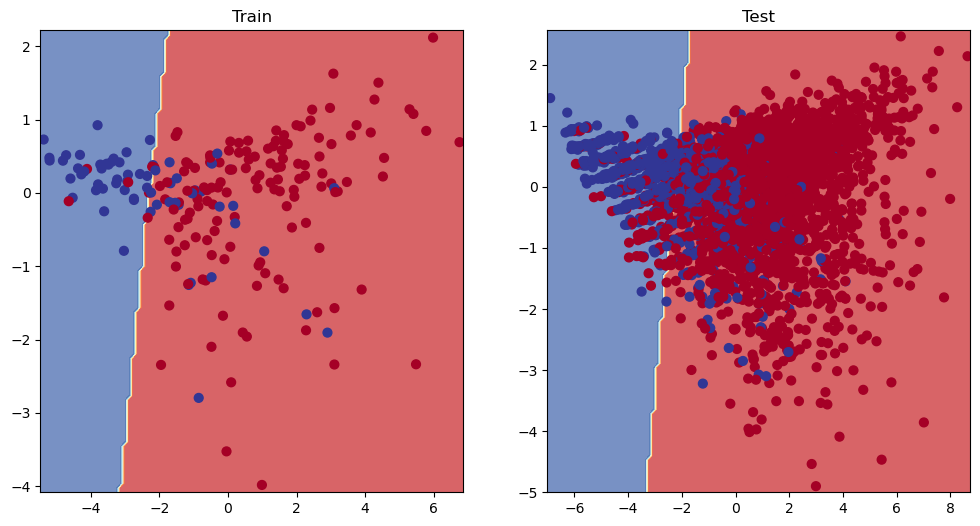

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")

plot_decision_boundary(class_model, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")

plot_decision_boundary(class_model, X_test, y_test)



We will now examine the test results more "directly" with a confusion matrix

In [28]:
ANN_con_matrix = confusion_matrix(y_test, test_pred) # constructing the confusion matrix

ANN_con_matrix

array([[2511,  183],
       [ 635,  640]], dtype=int64)

We will now visualize the confusion matrix

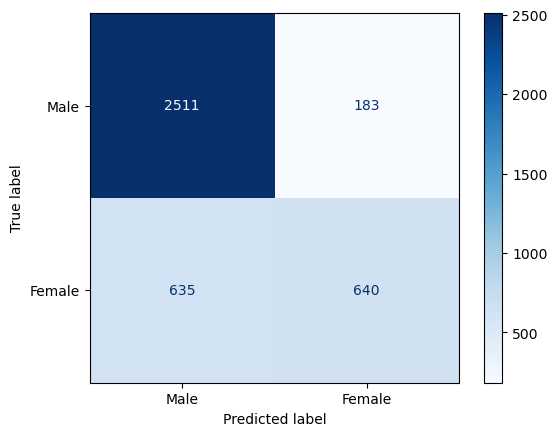

In [29]:
class_names = ["Male", "Female"] # class names

ANN_con_plot = ConfusionMatrixDisplay(confusion_matrix = ANN_con_matrix, display_labels = class_names) # making a displayer

ANN_con_plot.plot(cmap=plt.cm.Blues) # plotting it

plt.show() # using plt.show() to make it reliable when plotting

# Classification with K-nearest neighbour (KNN)

Another way to classify a dataset is by doing a KNN - we'll proceed to do that

The same dataset will be used as with the ANN

In [30]:
# train the model
knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train, y_train) # training / fitting the model

y_pred_knn = knn.predict(X_test)

# compute accuracy of the model
knn.score(X_test, y_test)

0.8034769463340892

In [31]:
knn_con_matrix = confusion_matrix(y_test, y_pred_knn)

knn_con_matrix

array([[2414,  280],
       [ 500,  775]], dtype=int64)

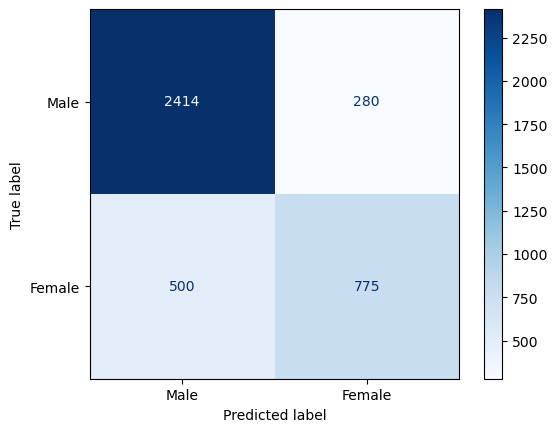

In [32]:
knn_con_plot = ConfusionMatrixDisplay(confusion_matrix = knn_con_matrix, display_labels = class_names) # making a displayer

knn_con_plot.plot(cmap=plt.cm.Blues) # plotting it

plt.show() # using plt.show() to make it reliable when plotting

# Classification with gaussian naive bayes classifier

We will now classify the dataset with the gaussian naive bayes classifier (GNB) - we will do the same process as with KNN

In [33]:
gnb_model = GaussianNB()

gnb_model.fit(X_train, y_train) # training / fitting the model

y_pred_gnb = gnb_model.predict(X_test)

gnb_model.score(X_test, y_test)

0.8042328042328042

Now constructing the confusion matrix

In [34]:
gnb_con_matrix = confusion_matrix(y_test, y_pred_gnb)

gnb_con_matrix

array([[2318,  376],
       [ 401,  874]], dtype=int64)

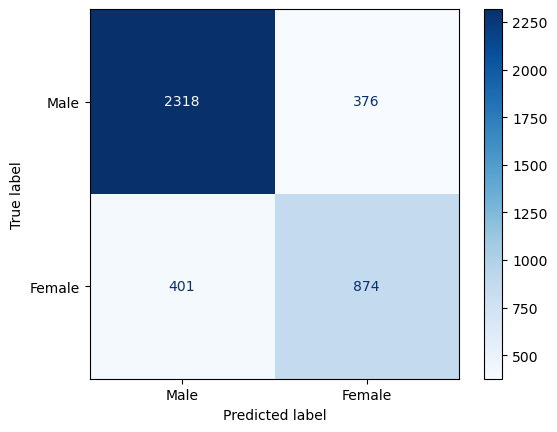

In [35]:
gnb_con_plot = ConfusionMatrixDisplay(confusion_matrix = gnb_con_matrix, display_labels = class_names) # making a displayer

gnb_con_plot.plot(cmap=plt.cm.Blues) # plotting it

plt.show() # using plt.show() to make it reliable when plotting

## Classification with Logistic regression

We will now try to do it with logistic regression

In [55]:
log_reg = LogisticRegression()

log_reg.fit(X_train, y_train) # training / fitting the model

y_pred_log = log_reg.predict(X_test)

log_reg.score(X_test, y_test)

0.7939027462836986

Now constructing the confusion matrix

In [37]:
log_con_matrix = confusion_matrix(y_test, y_pred_log)

log_con_matrix

array([[2393,  301],
       [ 517,  758]], dtype=int64)

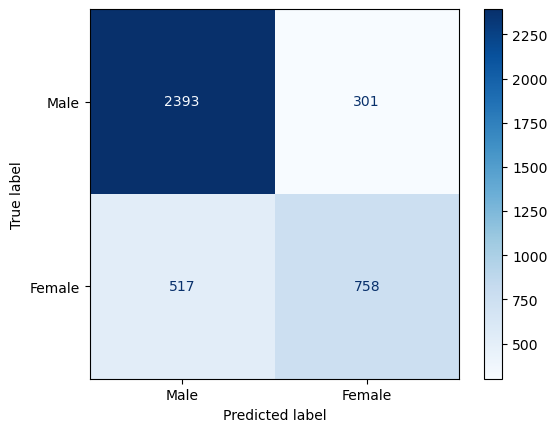

In [38]:
log_con_plot = ConfusionMatrixDisplay(confusion_matrix = log_con_matrix, display_labels = class_names) # making a displayer

log_con_plot.plot(cmap=plt.cm.Blues) # plotting it

plt.show() # using plt.show() to make it reliable when plotting

## Classification with support vector machines (SVM) ##

Why not try to classifiy with support vector machines instead? - that could be interesting to observe how it performs compared to the other classification methods

In [39]:
svm_class = svm.SVC(kernel="linear")

svm_class.fit(X_train, y_train) # training the SVM

y_pred_svm = svm_class.predict(X_test)

svm_class.score(X_test, y_test)

0.800453514739229

Not the best result - instead we should probably use a polynomial kernel to get a better accuracy

In [116]:
svm_class_poly = svm.SVC(kernel="poly", probability=True)

svm_class_poly.fit(X_train, y_train) # training the SVM

y_pred_svm_poly = svm_class_poly.predict(X_test)

svm_class_poly.score(X_test, y_test)

0.7752582514487276

This didn't help - why not try an RBF kernel instead with varying gamma-values?

In [117]:
svm_class_rbf = svm.SVC(kernel="rbf", gamma = 1.00, probability=True)

svm_class_rbf.fit(X_train, y_train) # training the SVM

y_pred_svm_rbf = svm_class_rbf.predict(X_test)

svm_class_rbf.score(X_test, y_test)

0.800705467372134

Lastly, we'll try to use the RandomizedSearchCV function to get the best combination.

In [118]:
svm_cv = svm.SVC()

kernel = ['linear', 'rbf', 'poly', 'sigmoid'] # the different kernels that will be used

c = [0.01, 0.1, 1, 10, 15, 20] # the different C-values for the SVM

gamma = [0.01, 0.1, 1, 1.5, 2] # the different gamma values for the SVM

svm_val = {'kernel': kernel, 'C': c, 'gamma' : gamma} # contain our value

svm_search = RandomizedSearchCV(svm_cv,
                                svm_val,
                                cv=5, 
                                return_train_score=True, 
                                n_iter=30,
                                verbose= 1,
                                refit = True)

svm_search.fit(X_train, y_train) # finding the best hyperparameters for our svm

print(svm_search.best_params_)

print(svm_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'kernel': 'sigmoid', 'gamma': 0.01, 'C': 20}
0.8364692218350754


# Lastly - trying to do a votingclassifier with the previous models!

In [119]:
voting_class_hard = VotingClassifier(estimators=[("LR",log_reg),
                                            ("KNN", knn), 
                                            ("GNB", gnb_model), 
                                            ("SVM", svm_class_rbf), 
                                            ("SVM poly", svm_class_poly)],
                                            voting = "hard")

voting_class_soft = VotingClassifier(estimators=[("LR",log_reg),
                                            ("KNN", knn), 
                                            ("GNB", gnb_model), 
                                            ("SVM", svm_class_rbf), 
                                            ("SVM poly", svm_class_poly)],
                                            voting = "soft")

In [120]:
voting_class_hard.fit(X_train, y_train)

voting_class_soft.fit(X_train, y_train)

hard_pred = voting_class_hard.predict(X_test)

soft_pred = voting_class_soft.predict(X_test)

#print(voting_class_soft.score(X_test, y_test))

print(voting_class_soft.score(X_test, y_test))

print(voting_class_hard.score(X_test, y_test))


0.8014613252708491
0.800957420005039


# Visualization for the votingclassifier

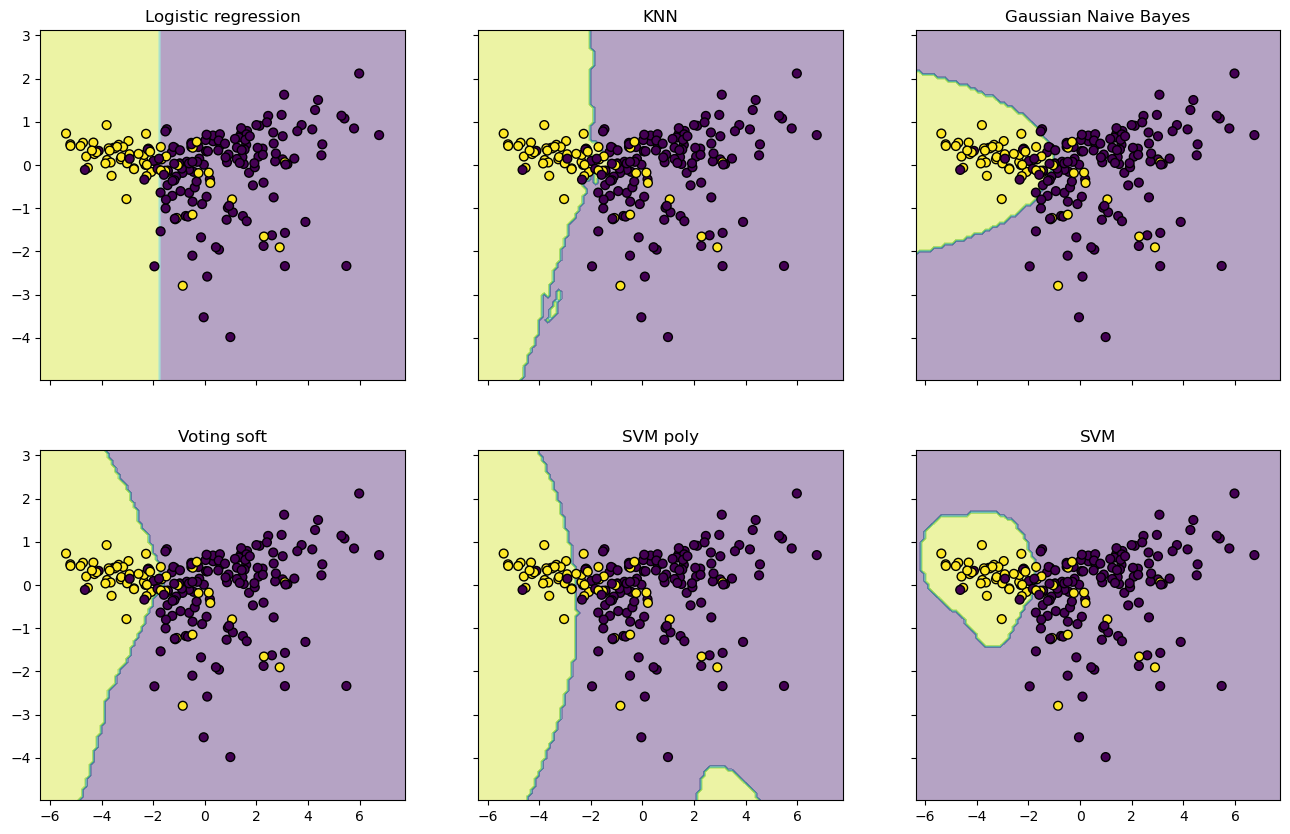

In [140]:
f, axarr = plt.subplots(2, 3, sharex="col", sharey="row", figsize=(16, 10))
for idx, clf, title in zip(
    product([0, 1], [0, 1, 2]),
    [log_reg, knn, gnb_model, voting_class_soft, svm_class_poly, svm_class_rbf],
    ["Logistic regression", "KNN", "Gaussian Naive Bayes", "Voting soft", "SVM poly", "SVM"],
):
    DecisionBoundaryDisplay.from_estimator(
        clf, X_train, alpha=0.4, ax=axarr[idx[0], idx[1]], response_method="predict"
    )
    axarr[idx[0], idx[1]].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, edgecolor="k")
    axarr[idx[0], idx[1]].set_title(title)

plt.show()

## Conclusion / remarks

It can be concluded, that the regression model is quite satisfactory with a R^2 of around 0,95 - we can thus estimate the viscera weight based on the other attributes.
Also there were no significant difference in performance for each method used in the regression model


With the classifaciton a couple of different ML-methods have been used, which in this case was ANN, KNN and GNB and lastly the Logistic regression, which overall got around 80% accuracy, which is not bad given the data. however, other methods could have been used as well and maybe even using some sort of bagging / boosting, but also using ensemble methods